<a href="https://colab.research.google.com/github/nstsj/Master_thesis_additional/blob/master/Appendix6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Metrics analysis**

As it was stated in the thesis, the traditional set of outcomes (TP, TN, FP, FN) and further design of Precision and Recall may appear insufficient when evaluating knowledge extraction from ill-defined domains.

This Appendix contains new suggested metrics, their explanation and example calculations.


# Approach \#1

The system may allow semantically close types of entities or relations. 

For example, in the sentence *“У меня уже полгода временами болит зуб, но сегодня заболело еще и горло”*, the piece *“болит зуб”* can be denoted as an entity of class ```“symptom”```, ```“complaint” ```or ```“anamnesis”```. 

In this case the extracted class $(c)$ should be counted as correct if it belongs to a set of possible classes $C$:

$\begin{equation}
  Correct(X) =
    \begin{cases}
      1 & \text{if  $c(X) ∈ C$}\\
      0 & \text{$otherwise$}
    \end{cases}       
\end{equation}$

$C ={\{c_1,c_2,...,c_n}\}$ <br> $C ∈ N$


In [0]:
def correct_entity_class_feeling_bad(x) -> str:
    """Takes a string as an input. This is a prototype. 
    Certain realisation depends on inner design of a particular evaluation system."""
    
    try:
        allowed = ["symptom", "complaint", "anamnesis"]
        if x in allowed:
            return x, 1
        else: return x,0
    except TypeError or ValueError or NameError:
        return "input must be string"

In [0]:
correct_entity_class_feeling_bad("complaint")

('complaint', 1)

In [0]:
correct_entity_class_feeling_bad("medical test")

('medical test', 0)

If a more sophisticated solution is required, an additional step may be included to calculate label probability. In this case the sum of all class probabilities should result in 1.
 
$\sum_{i=1}^{n} P(c_i) = 1$

Suppose, we have a text with 1000 extracted entities in a following proportion:
 - 200 enities of class ```"symptom"```
 - 300 entities of class ```"complaint"```
 - 120 entities of class ```"anamesis"```
 - 80 entities of class ```"medical test"```
 - 50 entities of class ```"location"```
 - 150 entities of class ```"actor"```
 - 100 entities of class ```"medical procedure"```
 
 Then we can count probability of correct labelling for cases when entities describe "unpleasant patient's sensations"

In [0]:
extracted = {"symptom":200,"complaint":300,"anamnesis":120,  # extracted entities and their freqs as dict
             "medical test":80,"location":50,"actor":150,
             "medical procedure":100}

def prob_correct_entity_class(x,y, *args):   #  correct classes as arguments; as many as required
    sum1 = extracted.get(x) + extracted.get(y) 

    if args: #if any additional arguments exist

        for i in args: #adding them to count sum of probabilities of correct classes
                sum2 = sum1 + extracted.get(i)
        return sum2/ sum(extracted.values()) 

    else: return sum1/sum(extracted.values()) #if only two arguments comprise correct set, opt for this branch
            
    

In [0]:
prob_correct_entity_class("symptom", "complaint")

0.5

In [0]:
prob_correct_entity_class("symptom", "complaint","anamnesis") 

0.62

#Approach \#2

*focuses on integral parameters for entities and relations that would allow a more neat evaluation of knowledge extraction.*

**“knowledge сompleteness”** <br> 
Since extracted knowledge is seen as a combination of entities and their relations (one can think of knowledge as a graph), it is important to evaluate which part of classes (for entities and relations) was extracted correctly.

$Completeness = \frac{1}{2}(\frac{TP_e}{TP_e+FN_e}+\frac{TP_r}{TP_r+FN_r})$ <br><br> 

where where $TP_e$ , $FN_e$ is the amount of true-positive and false negative examples for extracted entities, and $TP_r$ , $FN_r$ is the same for extracted relations. <br> 
$Completeness$ value ranges from $0$ to $1$

Suppose, we have a text with 1000 extracted entities and 650 relations. 

They are divided into groups as: <br>
*Entities (1000)*

|||*predicted*||   
|---|---|---|---|
|||pos|neg|
|*actual*|pos|$TP_e$ = 600 |$FN_e$ = 150|   
||neg|$FP_e$ = 50|$TN_e$ = 200|
   

*Relations (650)*

|||*predicted*||   
|---|---|---|---|
|||pos|neg|
|*actual*|pos|$TP_r$ = 400 |$FN_r$ = 100|   
||neg|$FP_r$ = 60|$TN_r$ = 90|

In [0]:
def completeness(ents, rels): 
    """ this function calculates completeness of an extracted knowledge in terms of correctly extracted entities and relations.
    Arguments are values for tp, fp, tn, fn as 2 dicts (entities+relations)"""

    entities_rec = ents.get('tp')/ (ents.get('tp') + ents.get('fn'))
    relations_rec = rels.get('tp')/ (rels.get('tp')+ rels.get('fn'))

    completeness = (entities_rec + relations_rec)/2
    return completeness

In [187]:
completeness (ents = {'tp':600, 'fn':150, 'fp':50, 'tn':200},
              rels = {'tp':400, 'fn':100, 'fp':60, 'tn':90})

0.8

The additional metric is **“knowledge similarity”**, which is calculated as graph edit distance between the gold standard and the result of a certain knowledge extraction system.

Graph Edit Distance is a set of graph edit operations (vertex and edge deletions, insertions, substitutions) required in order to transform the resulting graph into a golden one.

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

For instance, we can take the exapmle sentence "*У меня уже полгода временами болит зуб, но сегодня заболело еще и горло"*
 and construct two graphs: one is a gold standard (G) and the second as a result of some knowledge extraction system (H)

In [0]:
G = nx.DiGraph() #gold standard graph
G.add_node("actor")
G.add_node("anamnesis")
G.add_node("symptom")
G.add_edge("actor", "anamnesis", r = 'has')
G.add_edge("actor", "symptom", r = 'has')


H = nx.DiGraph() # second graph, simulated as if made by some knowledge extraction system
H.add_node("actor")
H.add_node("anamnesis")
H.add_node("symptom")
H.add_node("duration1", id = "уже полгода") #additional entities extracted
H.add_node("duration2", id = "вчера")
H.add_edge("actor", "anamnesis", r = 'has')
H.add_edge("actor", "symptom", r = 'has')
H.add_edge("symptom", "duration2", r = 'has') #additional edges
H.add_edge("anamnesis", "duration1", r = 'has')

knowledge_similarity = nx.algorithms.similarity.graph_edit_distance(G,H)

In [328]:
# let's calculate Graph Edit Distance between them
print("The difference between Gold standard graph (G) and the result graph(H) is ", knowledge_similarity)

the difference between Gold standard graph (G) and the result graph(H) is  4.0


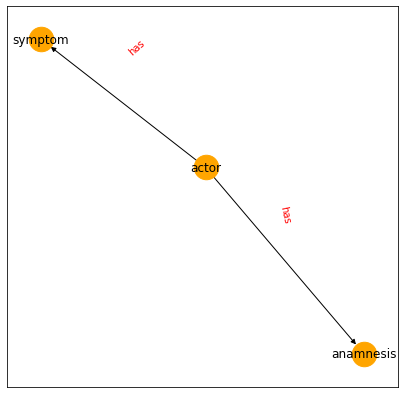

In [325]:
# let's look at them
plt.figure(figsize =(7,7))    
nx.draw_networkx(G, nodelist=G.nodes(), edgelist=G.edges(), node_color="orange", node_size=600)

nx.draw_networkx_edge_labels(G, pos, edge_labels = {('actor','symptom'):'has',\
('actor','anamnesis'):'has'},label_pos=0.5,font_color = "red" )

plt.show()


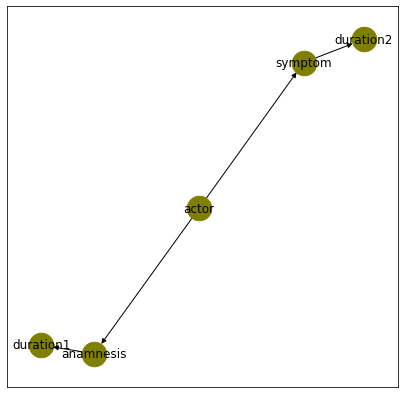

In [326]:
plt.figure(figsize =(7,7))    
nx.draw_networkx(H,nodelist=H.nodes(), edgelist=H.edges(), node_color="olive", node_size=600)


the next suggested parameter is **“credibility ratio” for relations**


if a relation between the extracted entities exists but seems implausible, it is suggested to take the extracted relation examples (labelled as FN and FP), and to additionally check pmi score between the two entities(x,y) that shared a relation.

The higher the pmi score, the more likely the words occur together. Thus it is possible to penalize rare entity pairs.
It is easier to use normalized pmi in evaluation, so 
 
 $npmi = pmi(x;y)/-log_2 p(x = X, y = Y)$<br>

  Normalized pmi ranges between [-1,+1] resulting in -1 for a word pair that almost never occurs together; +1 for a strong co-occurrence and 0 for the notions in between.  
  Then,<br>
   $Credibility = npmi(x,y)$, if $c(x) || c(y) ∈ Mistaken$<br>
$FP, FN ∈  Mistaken$ 

Then, the complete Precision and Recall formulae would look as: <br>
$Precision = TP/(TP+Credibility*FP)$ <br>
$Recall = TP/ (TP+Credibility*FN)$

for the previously used corpus, given Credibility = -0,7

*Relations (650)*

|||*predicted*||   
|---|---|---|---|
|||pos|neg|
|*actual*|pos|$TP_r$ = 400 |$FN_r$ = 100|   
||neg|$FP_r$ = 60|$TN_r$ = 90|

In [0]:
#  example here
rels = {'tp':400, 'fn':100, 'fp':60, 'tn':90}
def rel_metrics_credible(credibility):
    rel_recall = rels.get('tp')/ rels.get('tp') + rels.get('fn')*credibility
    rel_precision = rels.get('tp')/ rels.get('tp') + rels.get('fp')*credibility
    #F1 = 2 *((rel_precision* rel_recall) /  rel_recall+ rel_precision)
    return rel_recall, rel_precision

In [344]:
rel_metrics_credible(credibility= 0.7)


# further need to be scaled as for now can take negative values 

(71.0, 43.0)

In [0]:
#enother example here (calculate pmi for different pairs)

Another suggestion for evaluating knowledge extraction is using **“uncertainty coefficient”**

$U(X|Y) = (H(X)- H(X|Y)) / H(X) = I(X,Y)/H(X$ <br>
where $H$ is an entropy and $I$ is mutual information between an entity($X$) and relation($Y$) it may have

In [0]:
# add example here